In [54]:
# %pip install kaggle
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('shahrukhkhan/im2latex100k', path='./im2latex100k', unzip=True)

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install transformers torch torchvision
%pip install wandb
%pip install evaluate datasets jiwer -U
%pip install accelerate -U
%pip install scikit-learn -U

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a

In [55]:
import os, sys, itertools, glob

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['WANDB_NOTEBOOK_NAME'] = 'finetune_trocr_im2latex100k.ipynb'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset

import datasets
from datasets import load_dataset

import sklearn
from sklearn.model_selection import train_test_split

import transformers
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, default_data_collator

import evaluate

!git lfs install

git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log


In [56]:
MODEL_CKPT = "microsoft/trocr-large-printed"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-im2latex100k"

NUM_OF_EPOCHS = 7
BATCH_SIZE = 8
EVAL_BATCH_SIZE = 16

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

DEVICE = torch.device("cuda")
print(DEVICE)

cuda


In [57]:
import huggingface_hub

huggingface_hub.login()

import wandb

wandb.login()

wandb.init(project="finetune-trocr", config={
    "learning_rate": 2e-05,
    "architecture": "TrOCR",
    "dataset": "im2latex-100k",
    "epochs": NUM_OF_EPOCHS,
})


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/ubuntu/.cache/huggingface/token
Login successful


wandb: Currently logged in as: man-bibulatov. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


In [81]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)
print("Sklearn:".rjust(15), sklearn.__version__)

        Python: 3.10.1
        Pandas: 1.3.5
      Datasets: 2.17.0
         Torch: 2.0.1
  Transformers: 4.37.2
      Evaluate: 0.4.1
       Sklearn: 1.4.1.post1


In [82]:
hundred_k_train_df = pd.read_csv("./im2latex100k/im2latex_train.csv") 
hundred_k_test_df = pd.read_csv("./im2latex100k/im2latex_test.csv") 
hundred_k_validate_df = pd.read_csv("./im2latex100k/im2latex_validate.csv") 

print(f"Training Dataset Shape: {hundred_k_train_df.shape}")
print(f"Testing Dataset Shape: {hundred_k_test_df.shape}")
print(f"Testing Dataset Shape: {hundred_k_validate_df.shape}")

Training Dataset Shape: (75275, 2)
Testing Dataset Shape: (10355, 2)
Testing Dataset Shape: (8370, 2)


In [83]:
path_to_formulas = './im2latex230k/PRINTED_TEX_230k/final_png_formulas.txt'
image_names_path = './im2latex230k/PRINTED_TEX_230k/corresponding_png_images.txt'

with open(path_to_formulas, 'r') as f:
    formulas = [line.strip() for line in f if line.strip()]

with open(image_names_path, 'r') as f:
    images = [line.strip() for line in f if line.strip()]

two_hundred_thirty_k_df = pd.DataFrame({'formula': formulas, 'image': images})
two_hundred_thirty_k_df

formula                image
0       R _ { 1 2 } K _ { 1 } R _ { 2 1 } d K _ { 2 } ...  80f1db54ec657ab.png
1       E _ { n } - E _ { m } = \frac { \lambda ^ { \p...  4c0c01a5fb03248.png
2       \sigma ^ { 1 } + i \sigma ^ { 2 } = f ( \sigma...  3f55826fd850d77.png
3       B | _ { \partial \Sigma _ { 3 } } \rightarrow ...  a6a043f87f6ffdc.png
4       \phi _ { i } ^ { \prime } ( x ) = \phi _ { i }...  4d0e536147c711b.png
...                                                   ...                  ...
238324  < \tilde { \phi } _ { \omega } , \phi _ { \ome...  f39eae8d337aa45.png
238325  S = { \frac { 1 } { 8 \pi } } \int d x d y \le...  4300c834ccf1441.png
238326  A _ { \mu i j } ^ { a } = < \psi _ { j } ^ { a...  e905b0f81c6129c.png
238327  B _ { I } ( f , g ) = B _ { J } ( f , g ) , \q...  86ff16d9846059b.png
238328  ( D \Psi ^ { + } ) _ { e f f } = - { \frac { \...  48313fc05eeab78.png

[238329 rows x 2 columns]

In [84]:
hundred_k_train_df['image'] = './im2latex100k/formula_images_processed/formula_images_processed/' + hundred_k_train_df['image']
hundred_k_test_df['image'] = './im2latex100k/formula_images_processed/formula_images_processed/' + hundred_k_test_df['image']
hundred_k_validate_df['image'] = './im2latex100k/formula_images_processed/formula_images_processed/' + hundred_k_validate_df['image']

two_hundred_thirty_k_df['image'] = './im2latex230k/PRINTED_TEX_230k/generated_png_images/' + two_hundred_thirty_k_df['image']
hundred_k_validate_df

formula  \
0     \int _ { - \epsilon } ^ { \infty } d l \: \mat...   
1     [ { \bar { K } } _ { a } ^ { - } ( p ) , { \ba...   
2     E ( v ) = \frac { d } { d t } E ( q ) \; \; \;...   
3     { \frac { 1 } { L ^ { 2 } } } \prod _ { i = 1 ...   
4     x ^ { I } ( \sigma + 2 \pi , \tau ) = x ^ { I ...   
...                                                 ...   
8365  J = { \frac { 1 } { 2 } } \left[ { \frac { M _...   
8366  Z ( \beta ) = \int _ { \mu } ^ { \infty } d E ...   
8367  \lbrack { H , G _ { r i } } \rbrack = 0 , \qua...   
8368  J _ { 1 } ( i , j , 0 , 0 ; m ) = C ^ { ( 4 ) ...   
8369  { \cal L } = \bar { \psi } ( \partial \! \! \!...   

                                                  image  
0     ./im2latex100k/formula_images_processed/formul...  
1     ./im2latex100k/formula_images_processed/formul...  
2     ./im2latex100k/formula_images_processed/formul...  
3     ./im2latex100k/formula_images_processed/formul...  
4     ./im2latex100k/formula_images_processed/formul...  
...                                                 ...  
8365  ./im2latex100k/formula_images_processed/formul...  
8366  ./im2latex100k/formula_images_processed/formul...  
8367  ./im2latex100k/formula_images_processed/formul...  
8368  ./im2latex100k/formula_images_processed/formul...  
8369  ./im2latex100k/formula_images_processed/formul...  

[8370 rows x 2 columns]

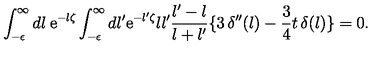

In [85]:
image = Image.open(hundred_k_validate_df['image'][0])
image

In [86]:
train_df = pd.concat([hundred_k_train_df, two_hundred_thirty_k_df], ignore_index=True)
# train_df, test_df = train_test_split(combined_train_df, test_size=0.1, shuffle=True, random_state=42)
train_df = train_df.reset_index(drop=True)
hundred_k_test_df = hundred_k_test_df.reset_index(drop=True)
train_df

formula  \
0       \widetilde \gamma _ { \mathrm { h o p f } } \s...   
1       ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \...   
2       S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ...   
3       \hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a ...   
4       \, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } ...   
...                                                   ...   
313599  < \tilde { \phi } _ { \omega } , \phi _ { \ome...   
313600  S = { \frac { 1 } { 8 \pi } } \int d x d y \le...   
313601  A _ { \mu i j } ^ { a } = < \psi _ { j } ^ { a...   
313602  B _ { I } ( f , g ) = B _ { J } ( f , g ) , \q...   
313603  ( D \Psi ^ { + } ) _ { e f f } = - { \frac { \...   

                                                    image  
0       ./im2latex100k/formula_images_processed/formul...  
1       ./im2latex100k/formula_images_processed/formul...  
2       ./im2latex100k/formula_images_processed/formul...  
3       ./im2latex100k/formula_images_processed/formul...  
4       ./im2latex100k/formula_images_processed/formul...  
...                                                   ...  
313599  ./im2latex230k/PRINTED_TEX_230k/generated_png_...  
313600  ./im2latex230k/PRINTED_TEX_230k/generated_png_...  
313601  ./im2latex230k/PRINTED_TEX_230k/generated_png_...  
313602  ./im2latex230k/PRINTED_TEX_230k/generated_png_...  
313603  ./im2latex230k/PRINTED_TEX_230k/generated_png_...  

[313604 rows x 2 columns]

In [87]:
print(f"Training Dataset Shape: {train_df.shape}")
print(f"Testing Dataset Shape: {hundred_k_test_df.shape}")

Training Dataset Shape: (313604, 2)
Testing Dataset Shape: (10355, 2)


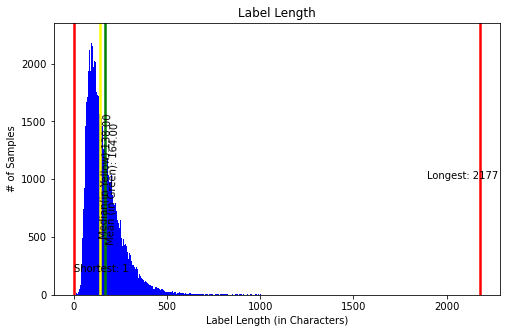

The string values range from 1 to 2177 characters.


In [88]:
temp_df = pd.concat([train_df, hundred_k_test_df])

temp_df['label_len'] = temp_df['formula'].str.len()

MIN_LENGTH_VALUE = int(min(temp_df['label_len']))
MAX_LENGTH_VALUE = int(max(temp_df['label_len']))
LENGTH_VALUE_MEAN = int(temp_df['label_len'].mean())
LENGTH_VALUE_MEDIAN = int(temp_df['label_len'].median())

graph_y_max = 1000

temp_df.hist("label_len",
             grid=False,
             color="Blue",
             figsize=(8, 5),
             bins=MAX_LENGTH_VALUE + 1,
             range=(0, MAX_LENGTH_VALUE + 1)
             )

plt.suptitle('')
plt.xlabel('Label Length (in Characters)')
plt.ylabel('# of Samples')
plt.title('Label Length')

# Display & label vertical line @ minimum value
plt.axvline(MIN_LENGTH_VALUE, color='red', linestyle='solid', linewidth=2.5)
plt.text(MIN_LENGTH_VALUE * 0.67, graph_y_max * 0.20, 'Shortest: {:.0f}'.format(MIN_LENGTH_VALUE))

# Display & label vertical line @ maximum value
plt.axvline(MAX_LENGTH_VALUE + 1, color='red', linestyle='solid', linewidth=2.5)
plt.text(MAX_LENGTH_VALUE * 0.87, graph_y_max * 1.00, 'Longest: {:.0f}'.format(MAX_LENGTH_VALUE))

# Display & label vertical line @ median value
plt.axvline(LENGTH_VALUE_MEDIAN,
            color='yellow',
            linestyle='solid',
            linewidth=2.5)

plt.text(LENGTH_VALUE_MEDIAN * 0.95,
         graph_y_max * 0.50,
         'Median(in Yellow):{:.2f}'.format(LENGTH_VALUE_MEDIAN),
         rotation=88)

# Display & label vertical line @ mean value
plt.axvline(LENGTH_VALUE_MEAN,
            color='green',
            linestyle='solid',
            linewidth=2.5)

plt.text(LENGTH_VALUE_MEAN * 1.025,
         graph_y_max * 0.45,
         'Mean (in Green): {:.2f}'.format(LENGTH_VALUE_MEAN),
         rotation=88)

plt.show()

print(f"The string values range from {MIN_LENGTH_VALUE} to {MAX_LENGTH_VALUE} characters.")
del temp_df

In [89]:
class Image2LatexDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df.iloc[idx]['image']
        text = self.df.iloc[idx]['formula']
        image = Image.open(file_name).convert("RGB")

        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(text, padding="max_length", truncation=True).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding


In [90]:
image_processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)

train_ds = Image2LatexDataset(df=train_df, processor=image_processor)
test_ds = Image2LatexDataset(df=hundred_k_test_df, processor=image_processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [91]:
print(f"The training dataset has {len(train_ds)} samples in it.")
print(f"The testing dataset has {len(test_ds)} samples in it.")

The training dataset has 313604 samples in it.
The testing dataset has 10355 samples in it.


In [93]:
encoding = train_ds[0]

for k, v in encoding.items():
    print(k.rjust(12, " "), ":", v.shape)

pixel_values : torch.Size([3, 384, 384])
      labels : torch.Size([512])


In [94]:
print(train_df['image'][0])

image = Image.open(train_df['image'][0]).convert("RGB")

image

./im2latex100k/formula_images_processed/formula_images_processed/66667cee5b.png


In [95]:
labels = encoding['labels']
labels[labels == -100] = image_processor.tokenizer.pad_token_id
label_str = image_processor.decode(labels, skip_special_tokens=True)
print(label_str)

\widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }


In [96]:
model = (
    VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-stage1')
).to(DEVICE)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [97]:
model.config.decoder_start_token_id = image_processor.tokenizer.cls_token_id
model.config.pad_token_id = image_processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = image_processor.tokenizer.sep_token_id
model.config.max_length = MAX_LENGTH_VALUE
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = -1
model.config.num_beams = 8

In [98]:
cer_metric = evaluate.load("cer")


def compute_metrics(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = image_processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = image_processor.tokenizer.pad_token_id
    label_str = image_processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [99]:
args = Seq2SeqTrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.0001,
    fp16=True,
    predict_with_generate=True,
    evaluation_strategy="no",
    save_strategy=STRATEGY,
    logging_strategy="steps",
    logging_steps=30,
    logging_first_step=True,
    lr_scheduler_type="inverse_sqrt",
    learning_rate=2e-05,
    report_to=["tensorboard","wandb"], 
    auto_find_batch_size=True,
    hub_private_repo=True,
    push_to_hub=True
)

In [100]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=image_processor.feature_extractor,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator,
)

/home/ubuntu/.local/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [101]:
train_results = trainer.train(resume_from_checkpoint=True)

KeyboardInterrupt: 

In [ ]:
trainer.save_model()
trainer.save_state()
wandb.finish()

In [23]:
metrics = trainer.evaluate()

/home/ubuntu/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1295: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print(f"The Character Error Rate (CER) for this model is {metrics['eval_cer']}")

In [ ]:
trainer.push_to_hub("model sucessfully fintuned")

In [ ]:
cer_score_as_dict = {"cer": metrics}
hyperparams = {"model": "trocr-large-printed"}

evaluate.save("ManBib/trocr-large-printed-im2latex100k/results/", experiment="v1", **cer_score_as_dict, **hyperparams)